<a href="https://colab.research.google.com/github/0Sensei2/Deep-Learning/blob/main/DeepL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras_preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.4 MB/s eta 0:00:00


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers, models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers import Resizing, Rescaling
from PIL import Image

from pathlib import Path
import os.path
import random
import datetime

import matplotlib.cm as cm
import cv2
import seaborn as sns

sns.set_style('white')

from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [50]:

# Parameter
BATCH_SIZE = 128
TARGET_SIZE = (160, 160)

# Path dataset
dataset = "/content/drive/MyDrive/DeepL"

def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"Ada {len(dirnames)} folder dan {len(filenames)} file di direktori: {dirpath}")

walk_through_dir(dataset)

Ada 4 folder dan 1 file di direktori: /content/drive/MyDrive/DeepL
Ada 0 folder dan 320 file di direktori: /content/drive/MyDrive/DeepL/Gitar
Ada 0 folder dan 322 file di direktori: /content/drive/MyDrive/DeepL/piano
Ada 0 folder dan 306 file di direktori: /content/drive/MyDrive/DeepL/Harmonika
Ada 0 folder dan 316 file di direktori: /content/drive/MyDrive/DeepL/Suling


In [36]:

image_dir = Path(dataset)

# Dapatkan jalur file dan label
filepaths = list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Jenis')

# Gabungkan jalur file dan label
image_df = pd.concat([filepaths, labels], axis=1)

<ipython-input-37-b43f6afc3956>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')


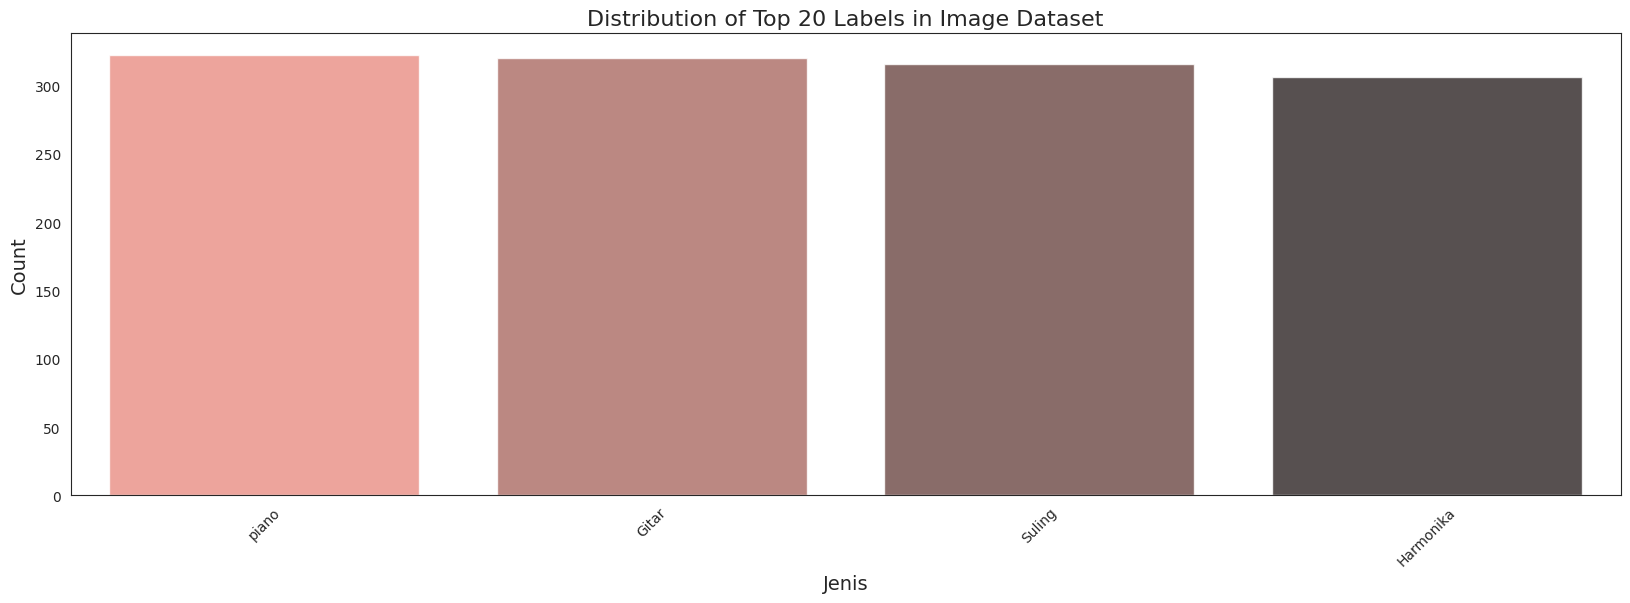

In [37]:

# Dapatkan 20 label teratas
label_counts = image_df['Jenis'].value_counts()[:20]

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')
plt.title('Distribution of Top 20 Labels in Image Dataset', fontsize=16)
plt.xlabel('Jenis', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

<ipython-input-51-a6efaaaa7b77>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = image_df.groupby('Jenis', group_keys=False).apply(lambda x: x.sample(2)).reset_index(drop=True)


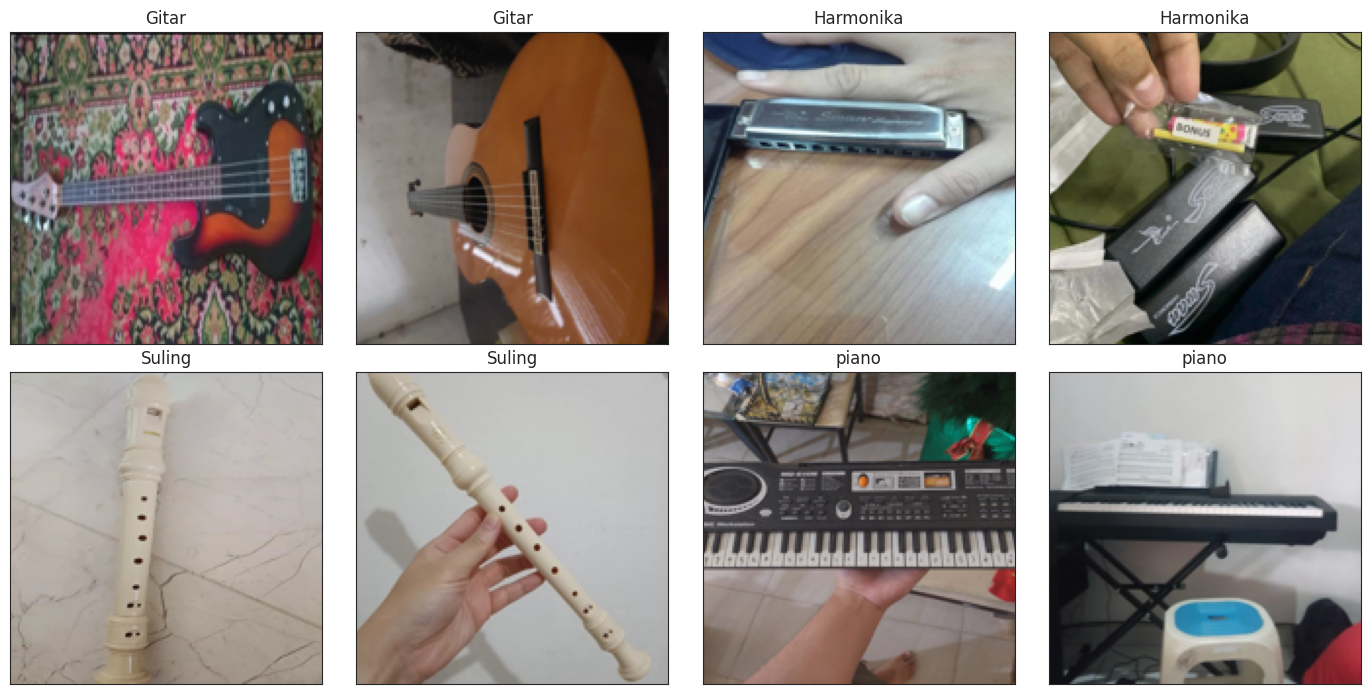

In [51]:
# Ambil 2 gambar acak dari tiap kelas
sample_df = image_df.groupby('Jenis', group_keys=False).apply(lambda x: x.sample(2)).reset_index(drop=True)

# Plot gambar-gambar
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 7), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = sample_df.Filepath[i]
    label = sample_df.Jenis[i]

    # Membaca gambar dan mengubah ukuran menjadi persegi
    img = Image.open(img_path)
    img_resized = img.resize((160, 160))

    ax.imshow(img_resized)
    ax.set_title(label)

plt.tight_layout()
plt.show()

In [39]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # Membaca gambar yang terkompres
    compressed_img = cv2.imread(temp_filename)

    # Dapatkan perbedaan absolut antara img1 dan img2 dan kalikan dengan skala
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality=quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image


def random_sample(path, extension=None):
    # Pilih gambar acak dari folder
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')

    items = list(items)

    p = random.choice(items)
    return p.as_posix()

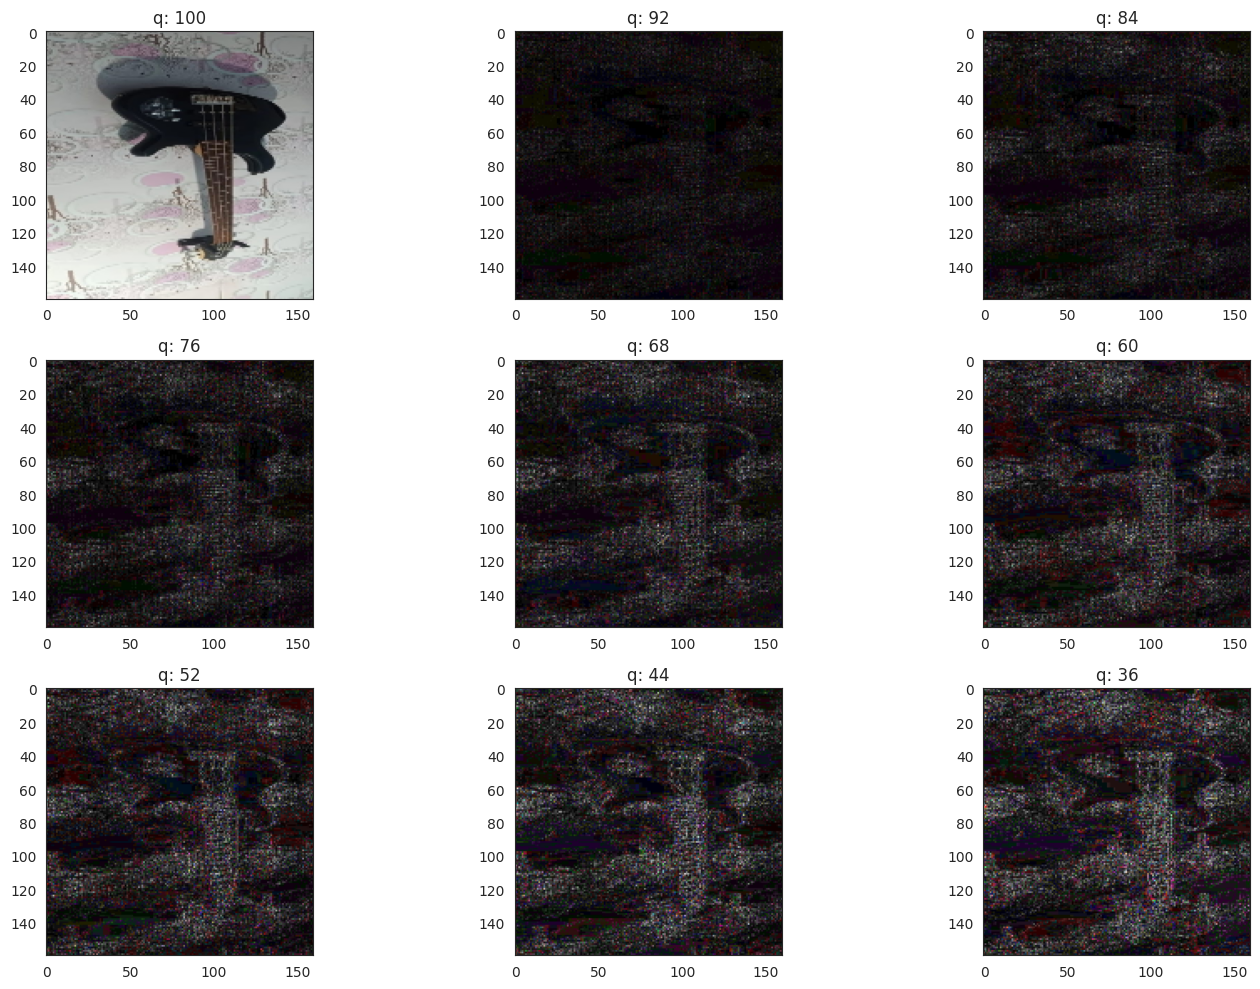

In [52]:
# Lihat sampel acak dari kumpulan data dan terapkan ELA
sample_class = 'Gitar'
dataset_path = '/content/drive/MyDrive/DeepL'
p = random_sample(f'{dataset_path}/{sample_class}')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0

# Inisialisasi parameter
init_val = 100
columns = 3
rows = 3

# Membuat figure untuk plot
fig = plt.figure(figsize=(15, 10))

for i in range(1, columns * rows + 1):
    quality = init_val - (i - 1) * 8  # Menurunkan kualitas kompresi untuk setiap gambar
    img = compute_ela_cv(path=p, quality=quality)

    if i == 1:
        img = orig.copy()  # Gambar asli di posisi pertama

    # Mengubah ukuran gambar menjadi persegi
    img_resized = cv2.resize(img, (160, 160))  # Ganti 160 dengan ukuran yang diinginkan

    # Menambahkan gambar yang telah diresize ke dalam subplot
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img_resized)

plt.tight_layout()
plt.show()

In [53]:
train_val_df, test_df = train_test_split(image_df, test_size=0.10, shuffle=True, random_state=42, stratify=image_df['Jenis'])

train_df, val_df = train_test_split(train_val_df, test_size=1/3, shuffle=True, random_state=42, stratify=train_val_df['Jenis'])

# Konfirmasi ukuran
print(f"Jumlah data latih: {len(train_df)}")
print(f"Jumlah data validasi: {len(val_df)}")
print(f"Jumlah data uji: {len(test_df)}")


Jumlah data latih: 758
Jumlah data validasi: 379
Jumlah data uji: 127


In [54]:
# Membuat generator untuk data latih, validasi, dan uji
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

val_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)


In [55]:
# Membuat data generator untuk training
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Jenis',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

# Membuat data generator untuk validasi
val_images = val_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Jenis',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

# Membuat data generator untuk testing
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Jenis',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 758 validated image filenames belonging to 4 classes.
Found 379 validated image filenames belonging to 4 classes.
Found 127 validated image filenames belonging to 4 classes.


In [56]:
# Langkah Augmentasi Data
augment = tf.keras.Sequential([
    layers.Resizing(160, 160),
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.4),
    layers.RandomZoom(0.4),
    layers.RandomContrast(0.4),
    layers.RandomTranslation(0.2, 0.2),
])

In [57]:
pretrained_model = MobileNetV2(
    input_shape=(160, 160, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)
pretrained_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [58]:

# Buat callback checkpoint
checkpoint_path = "alat_musik.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Siapkan  EarlyStopping untuk menghentikan pelatihan
early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 10,
                               restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [59]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(64, activation='relu')(pretrained_model.output)
x = Dropout(0.6)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


outputs = Dense(len(train_images.class_indices), activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = os.path.join(dir_name, experiment_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return TensorBoard(log_dir=log_dir)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=55,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "alat_musik"),
        checkpoint_callback,
        reduce_lr
    ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/55
6/6 ━━━━━━━━━━━━━━━━━━━━ 79s 13s/step - accuracy: 0.2736 - loss: 3.7843 - val_accuracy: 0.2929 - val_loss: 1.9942 - learning_rate: 5.0000e-05
Epoch 2/55
6/6 ━━━━━━━━━━━━━━━━━━━━ 59s 10s/step - accuracy: 0.2699 - loss: 3.3207 - val_accuracy: 0.3193 - val_loss: 1.6489 - learning_rate: 5.0000e-05
Epoch 3/55
6/6 ━━━━━━━━━━━━━━━━━━━━ 81s 10s/step - accuracy: 0.2512 - loss: 3.0500 - val_accuracy: 0.3404 - val_loss: 1.4484 - learning_rate: 5.0000e-05
Epoch 4/55
6/6 ━━━━━━━━━━━━━━━━━━━━ 68s 12s/step - accuracy: 0.2846 - loss: 2.6040 - val_accuracy: 0.4222 - val_loss: 1.3211 - learning_rate: 5.0000e-05
Epoch 5/55
6/6 ━━━━━━━━━━━━━━━━━━━━ 58s 10s/step - accuracy: 0.2995 - loss: 2.3855 - val_accuracy: 0.4512 - val_loss: 1.2398 - learning_rate: 5.0000e-05
Epoch 6/55
6/6 ━━━━━━━━━━━━━━━━━━━━ 82s 10s/step - accuracy: 0.3267 - loss: 2.0527 - val_accuracy: 0.4934 - val_loss: 1.1827 - learning_rate: 5.0000e-05
Epoch 7/55
6/6 ━━━━━━━━━━━━━━━━━━━━ 104s 14s/step - accuracy: 0.3066 - loss: 1.957

In [61]:
#Evaluasi Model
results = model.evaluate(test_images, verbose=0)
#Tampilan Hasil
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.42106
Test Accuracy: 88.98%


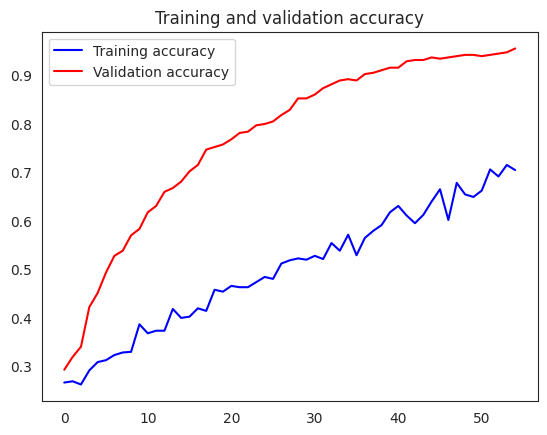

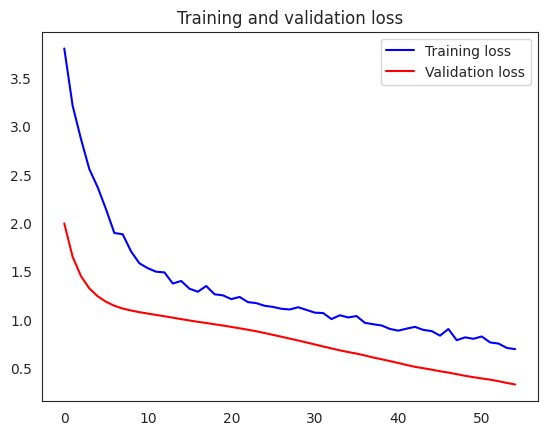

In [60]:
#Pengambilan Data Akurasi dan Loss
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
#Plot training dan accuracy loss
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


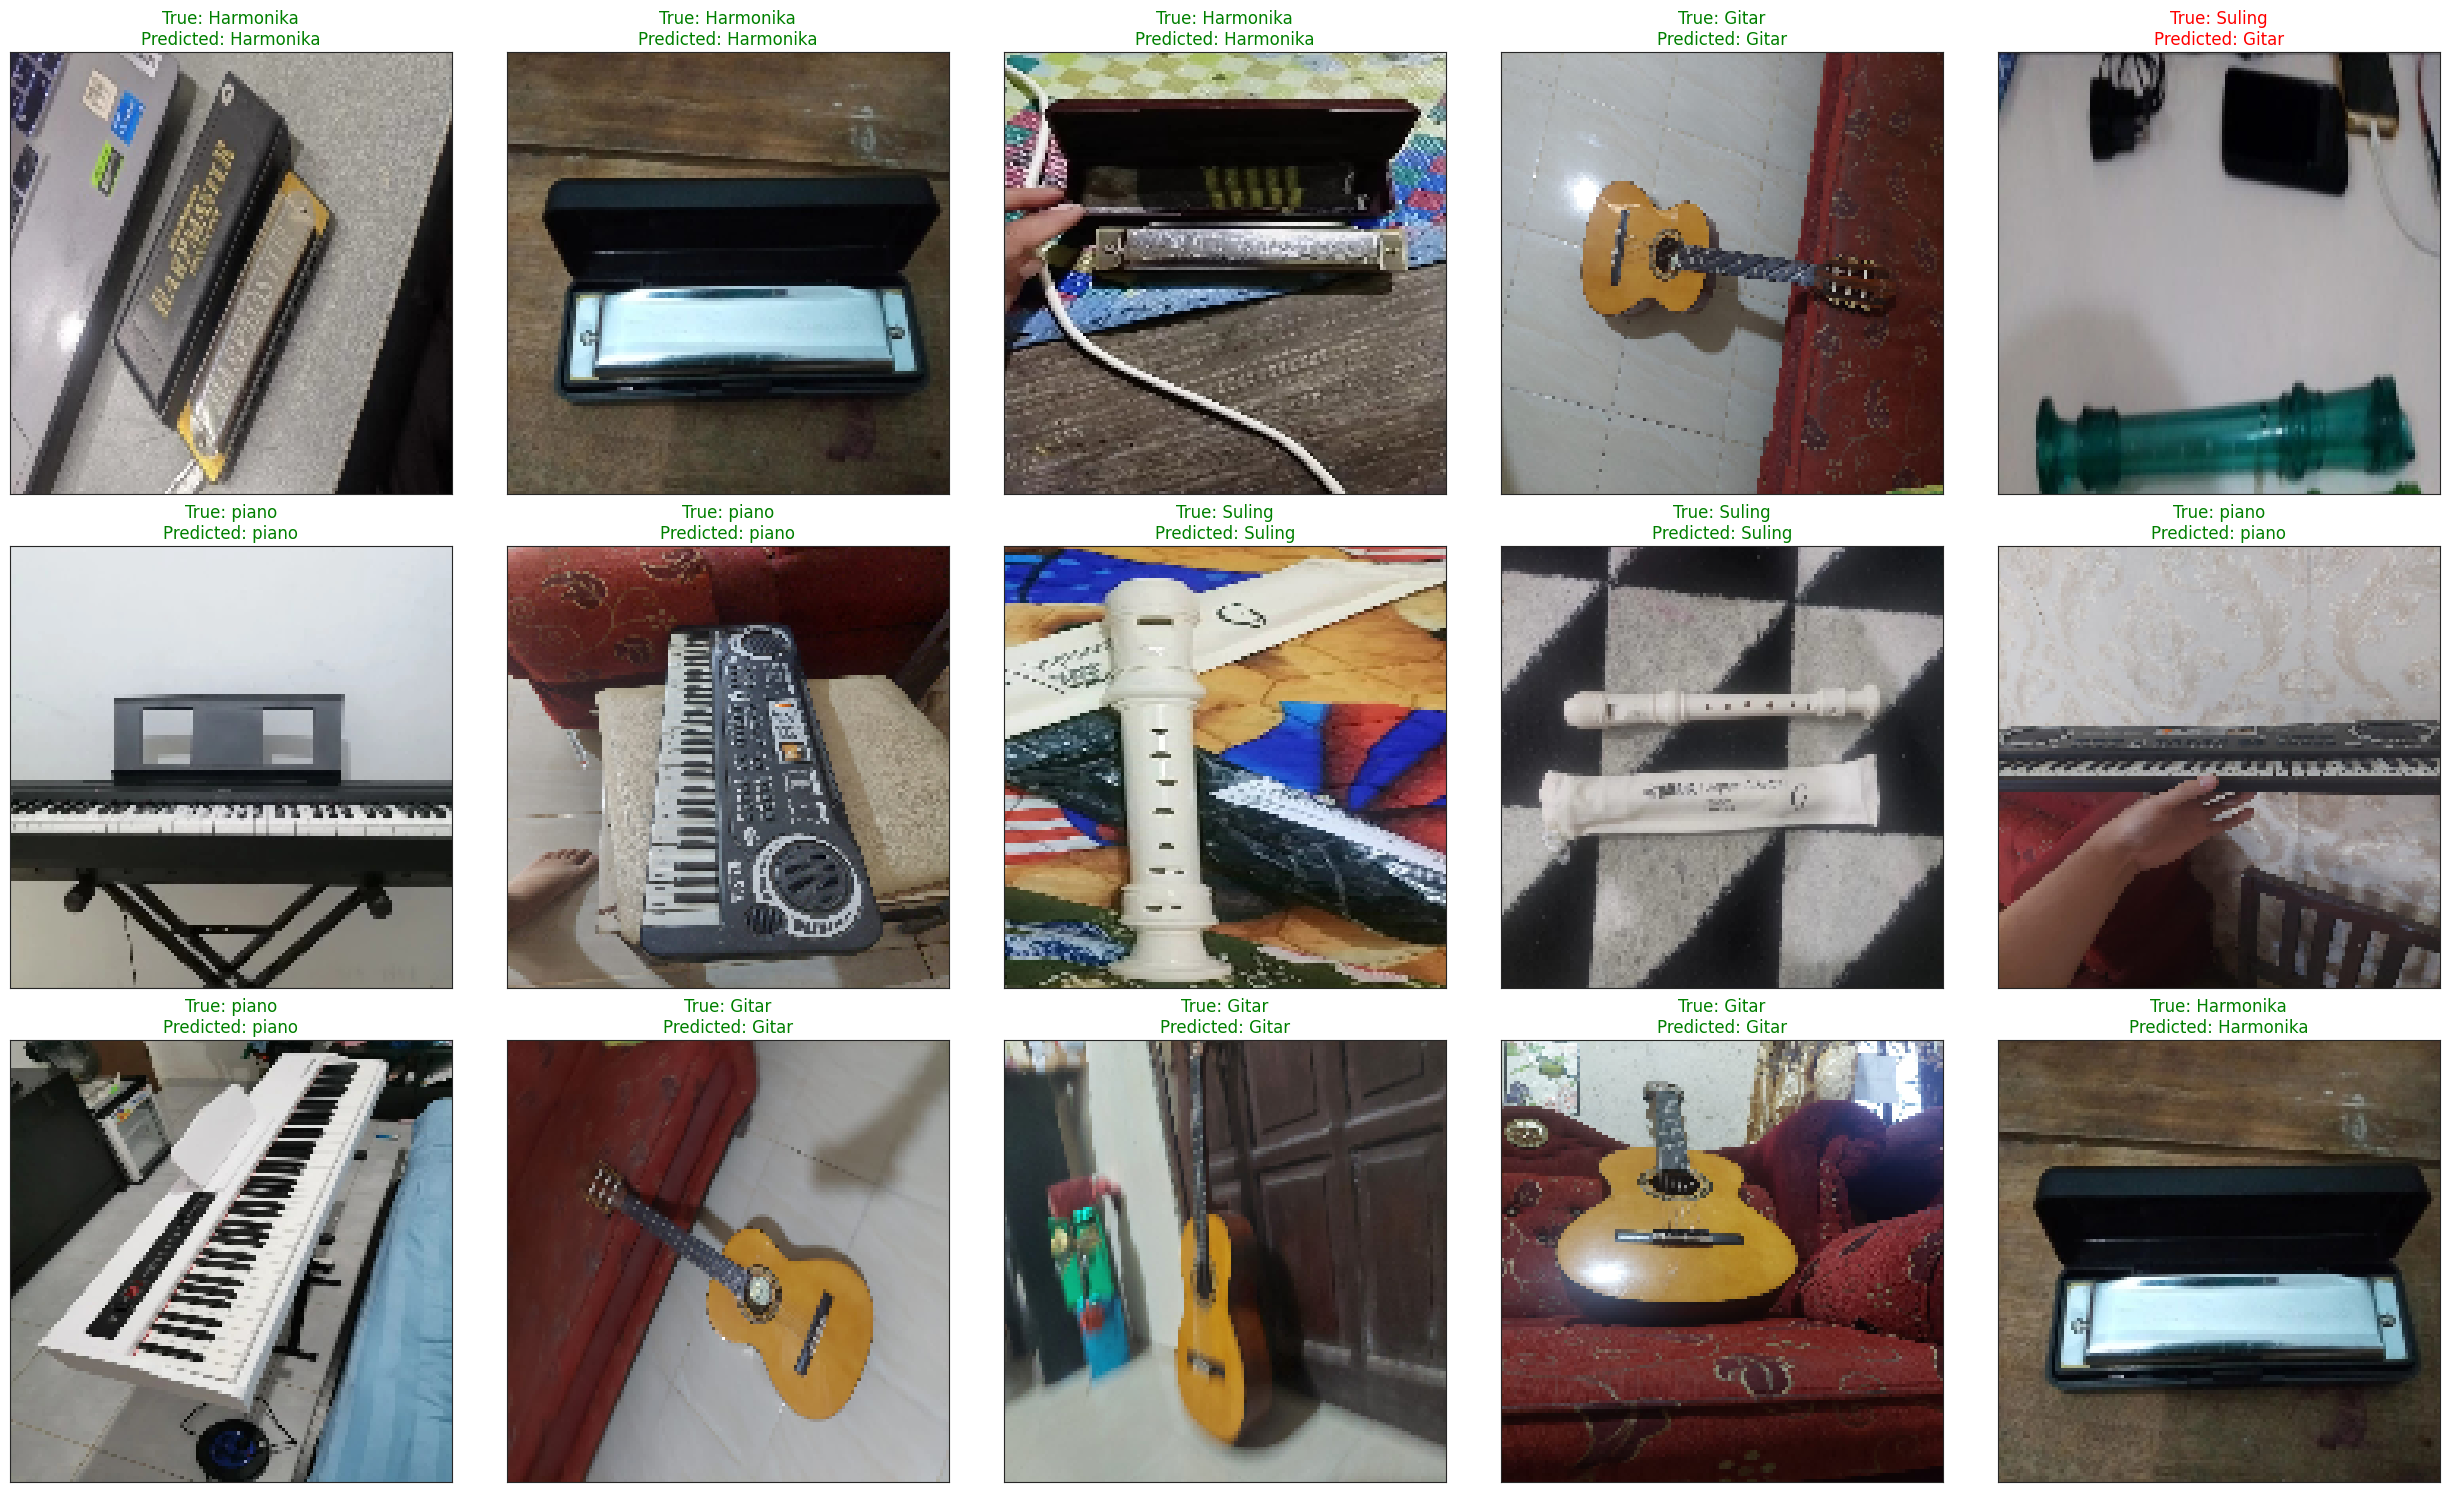

In [62]:
#Making Predictions on the Test Data

# Predict label image
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Petakan label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Menampilkan 20 gambar acak dari dataset dengan labelnya
random_index = np.random.randint(0, len(test_df) - 1, 20)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

resize_dim = (140, 140)

for i, ax in enumerate(axes.flat):
    img = plt.imread(test_df.Filepath.iloc[random_index[i]])
    img_resized = cv2.resize(img, resize_dim)
    ax.imshow(img_resized)

    if test_df.Jenis.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"

    ax.set_title(f"True: {test_df.Jenis.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)

plt.tight_layout()
plt.show()

In [63]:

y_test = list(test_df.Jenis)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       Gitar       0.86      0.97      0.91        32
   Harmonika       0.93      0.81      0.86        31
      Suling       0.82      0.84      0.83        32
       piano       0.97      0.94      0.95        32

    accuracy                           0.89       127
   macro avg       0.89      0.89      0.89       127
weighted avg       0.89      0.89      0.89       127



In [64]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score     support
Gitar          0.861111  0.968750  0.911765   32.000000
Harmonika      0.925926  0.806452  0.862069   31.000000
Suling         0.818182  0.843750  0.830769   32.000000
piano          0.967742  0.937500  0.952381   32.000000
accuracy       0.889764  0.889764  0.889764    0.889764
macro avg      0.893240  0.889113  0.889246  127.000000
weighted avg   0.892983  0.889764  0.889460  127.000000

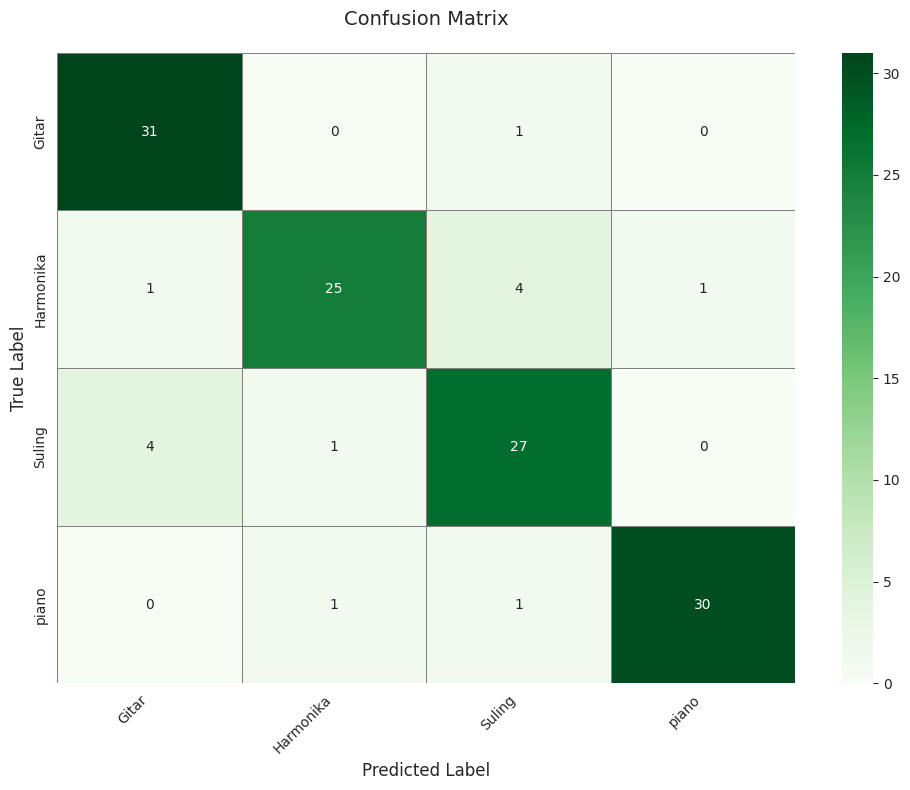

In [65]:
import matplotlib.cm as cm
# Menghitung confusion matrix
cm = confusion_matrix(y_test, pred)

# Normalisasi (opsional, hasil tetap sama jika normalize=False)
normalize = False  # Set True untuk menampilkan persentase
if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix dengan heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    cm,
    annot=True,
    fmt='.2f' if normalize else 'd',  # Format: persen jika normalize, integer jika tidak
    cmap='Greens',                     # Ganti colormap: 'Oranges', 'Reds', 'Purples', dll.
    linewidths=0.5,                    # Tambahkan border antar sel
    linecolor='gray',
    xticklabels=test_images.class_indices.keys(),
    yticklabels=test_images.class_indices.keys()
)

# Atur judul dan label
plt.title('Confusion Matrix', fontsize=14, pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

# Rotasi label sumbu x
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()  # Agar tidak ada teks yang terpotong
plt.show()

In [66]:
def get_img_array(img_path, size):
    """Membaca gambar, resize, dan konversi ke array dengan batch dimension."""
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = preprocess_input(array)  # Preprocessing khusus ResNet50
    array = np.expand_dims(array, axis=0)  # Menambahkan batch dimension
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Membuat heatmap Grad-CAM untuk model ResNet50."""
    # Membuat model baru yang mengeluarkan output layer konvolusi terakhir dan prediksi
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Menghitung gradien kelas terprediksi terhadap feature map
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Gradien dari kelas terprediksi terhadap output layer konvolusi
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Pooling gradien untuk mendapatkan importance weights tiap channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Membuat heatmap dengan menggabungkan feature map dan pooled gradients
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalisasi heatmap antara 0 dan 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    """Menyimpan dan menampilkan hasil Grad-CAM."""
    # Memuat gambar asli
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap ke 0-255 dan beri warna menggunakan colormap 'jet'
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Ubah heatmap ke format gambar dan resize sesuai gambar asli
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Gabungkan heatmap dengan gambar asli
    superimposed_img = jet_heatmap * alpha + img * (1 - alpha)  # Blending lebih baik
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)

    return cam_path

# Preprocessing khusus ResNet50
preprocess_input = tf.keras.applications.resnet50.preprocess_input
decode_predictions = tf.keras.applications.resnet50.decode_predictions

# Layer konvolusi terakhir di ResNet50 (bisa 'conv5_block3_out' atau 'conv5_block3_3_conv')
last_conv_layer_name = "conv5_block3_out"  # Untuk ResNet50 standar
img_size = (224, 224)  # Ukuran input ResNet50

# Nonaktifkan softmax di layer terakhir jika ada
if hasattr(model.layers[-1], 'activation'):
    model.layers[-1].activation = None

ValueError: No such layer: conv5_block3_out. Existing layers are: ['input_layer_9', 'Conv1', 'bn_Conv1', 'Conv1_relu', 'expanded_conv_depthwise', 'expanded_conv_depthwise_BN', 'expanded_conv_depthwise_relu', 'expanded_conv_project', 'expanded_conv_project_BN', 'block_1_expand', 'block_1_expand_BN', 'block_1_expand_relu', 'block_1_pad', 'block_1_depthwise', 'block_1_depthwise_BN', 'block_1_depthwise_relu', 'block_1_project', 'block_1_project_BN', 'block_2_expand', 'block_2_expand_BN', 'block_2_expand_relu', 'block_2_depthwise', 'block_2_depthwise_BN', 'block_2_depthwise_relu', 'block_2_project', 'block_2_project_BN', 'block_2_add', 'block_3_expand', 'block_3_expand_BN', 'block_3_expand_relu', 'block_3_pad', 'block_3_depthwise', 'block_3_depthwise_BN', 'block_3_depthwise_relu', 'block_3_project', 'block_3_project_BN', 'block_4_expand', 'block_4_expand_BN', 'block_4_expand_relu', 'block_4_depthwise', 'block_4_depthwise_BN', 'block_4_depthwise_relu', 'block_4_project', 'block_4_project_BN', 'block_4_add', 'block_5_expand', 'block_5_expand_BN', 'block_5_expand_relu', 'block_5_depthwise', 'block_5_depthwise_BN', 'block_5_depthwise_relu', 'block_5_project', 'block_5_project_BN', 'block_5_add', 'block_6_expand', 'block_6_expand_BN', 'block_6_expand_relu', 'block_6_pad', 'block_6_depthwise', 'block_6_depthwise_BN', 'block_6_depthwise_relu', 'block_6_project', 'block_6_project_BN', 'block_7_expand', 'block_7_expand_BN', 'block_7_expand_relu', 'block_7_depthwise', 'block_7_depthwise_BN', 'block_7_depthwise_relu', 'block_7_project', 'block_7_project_BN', 'block_7_add', 'block_8_expand', 'block_8_expand_BN', 'block_8_expand_relu', 'block_8_depthwise', 'block_8_depthwise_BN', 'block_8_depthwise_relu', 'block_8_project', 'block_8_project_BN', 'block_8_add', 'block_9_expand', 'block_9_expand_BN', 'block_9_expand_relu', 'block_9_depthwise', 'block_9_depthwise_BN', 'block_9_depthwise_relu', 'block_9_project', 'block_9_project_BN', 'block_9_add', 'block_10_expand', 'block_10_expand_BN', 'block_10_expand_relu', 'block_10_depthwise', 'block_10_depthwise_BN', 'block_10_depthwise_relu', 'block_10_project', 'block_10_project_BN', 'block_11_expand', 'block_11_expand_BN', 'block_11_expand_relu', 'block_11_depthwise', 'block_11_depthwise_BN', 'block_11_depthwise_relu', 'block_11_project', 'block_11_project_BN', 'block_11_add', 'block_12_expand', 'block_12_expand_BN', 'block_12_expand_relu', 'block_12_depthwise', 'block_12_depthwise_BN', 'block_12_depthwise_relu', 'block_12_project', 'block_12_project_BN', 'block_12_add', 'block_13_expand', 'block_13_expand_BN', 'block_13_expand_relu', 'block_13_pad', 'block_13_depthwise', 'block_13_depthwise_BN', 'block_13_depthwise_relu', 'block_13_project', 'block_13_project_BN', 'block_14_expand', 'block_14_expand_BN', 'block_14_expand_relu', 'block_14_depthwise', 'block_14_depthwise_BN', 'block_14_depthwise_relu', 'block_14_project', 'block_14_project_BN', 'block_14_add', 'block_15_expand', 'block_15_expand_BN', 'block_15_expand_relu', 'block_15_depthwise', 'block_15_depthwise_BN', 'block_15_depthwise_relu', 'block_15_project', 'block_15_project_BN', 'block_15_add', 'block_16_expand', 'block_16_expand_BN', 'block_16_expand_relu', 'block_16_depthwise', 'block_16_depthwise_BN', 'block_16_depthwise_relu', 'block_16_project', 'block_16_project_BN', 'Conv_1', 'Conv_1_bn', 'out_relu', 'global_max_pooling2d_7', 'dense_12', 'dropout_8', 'dense_13', 'dropout_9', 'dense_14'].

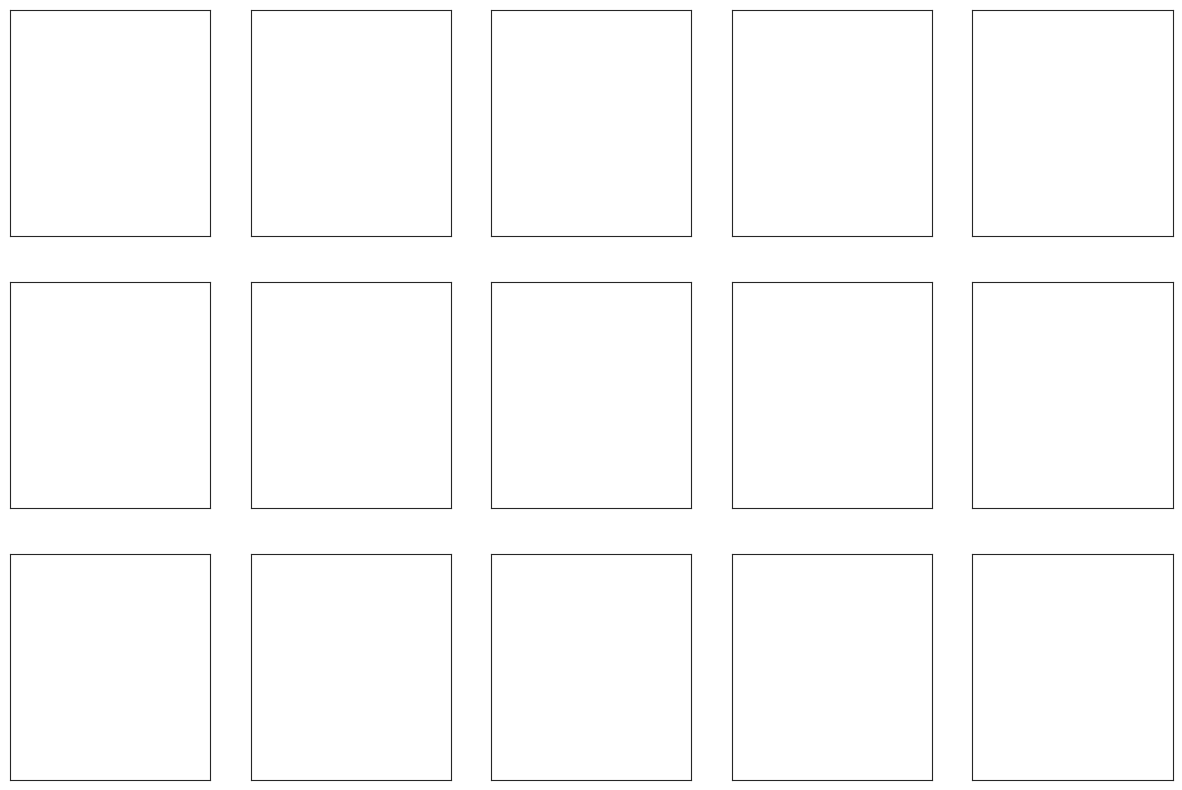

In [68]:
# Tampilkan bagian gambar yang digunakan oleh jaringan saraf untuk mengklasifikasikan gambar
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

resize_dim = (160, 160)

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)

    img_resized = cv2.resize(plt.imread(cam_path), resize_dim)

    ax.imshow(img_resized)
    ax.set_title(f"True: {test_df.Jenis.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")

plt.tight_layout()
plt.show()